## Building the graph

### Clipping: All except colabs mentioning "javascript" + Colabs mentioning only "Python"

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [86]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [87]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [88]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [89]:
#All except colabs mentioning "javascript" + Colabs mentioning only "Python
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'javascript' in str(x).lower() or 'js' in str(x).lower())]
data = data[data['BODY'].notna() & (data['BODY'].str.lower().str.contains('python|py', case=False))]

In [90]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [91]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
19,CarlosX,2015-01-01T00:12:02Z,Happy new year! xD,Arctium
23,foosel,2015-01-01T00:13:42Z,The new app api keys are documented [here](htt...,alexrj
50,j2sol,2015-01-01T00:26:09Z,Looks like copypasta. a2dissite_binary in the ...,blueboxgroup
171,arrmo,2015-01-01T01:12:06Z,"Hi,\r\n\r\nFor some reason I just got notified...",snazy2000
208,ldo,2015-01-01T01:26:19Z,Unnecessary. Callers already check `PyErr_Occu...,reubenhwk
...,...,...,...,...
634935,kuba,2015-02-28T07:31:52Z,For the time being I follow the policy that on...,letsencrypt
635048,DoumanAsh,2015-02-28T08:24:43Z,Maybe it would be more right just to store con...,pmzqla
635058,ahmedre,2015-02-28T08:28:40Z,this is possibly a hack - open to suggestions ...,square
635180,ace2nutzer,2015-02-28T09:06:51Z,thank u....\r\n\r\nroot@codinap:/ # cat /proc/...,ace2nutzer


In [92]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
jirikuncar         1317
mister-roboto       484
biocad-teamcity     135
kaplun              117
linthubot           100
                   ... 
fraxedas              1
frapposelli           1
frapell               1
franzliedke           1
jdalton               1
Name: source, Length: 7362, dtype: int64

In [93]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    7362.000000
mean        2.673051
std        16.958727
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max      1317.000000
Name: source, dtype: float64

In [94]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['jirikuncar', 'plone', 'edx', 'mozilla', 'apache', 'scikit-learn',
       'hpcugent', 'bartvm', 'django', 'Stanford-Online',
       ...
       'adsabs', 'snowplow', 'moneyadviceservice', 'adform', 'adicu',
       'duckduckgo', 'idaholab', 'MovingBlocks', 'btb', 'soft-matter'],
      dtype='object', name='source', length=675)

In [95]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [96]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
50,j2sol,2015-01-01T00:26:09Z,Looks like copypasta. a2dissite_binary in the ...,blueboxgroup
260,berkerpeksag,2015-01-01T01:43:01Z,I'd start with `$ PYTHONPATH=. python ...` here.,spotify
301,pbrunet,2015-01-01T10:02:12Z,I think you should make it recursive once the ...,serge-sans-paille
323,CyberShadow,2015-01-01T10:14:42Z,I wasn't thinking of C++ iterators when I chos...,D-Programming-Language
463,Minecrell,2015-01-01T11:42:11Z,"This has to be an immutable map, you can eithe...",SpongePowered
...,...,...,...,...
634853,konklone,2015-02-28T06:53:59Z,Django does have an idea of what environment i...,18F
634880,NTaylorMullen,2015-02-28T07:04:39Z,"Hmmm, should our `CopyTo`s be clearing the con...",aspnet
634882,NTaylorMullen,2015-02-28T07:05:28Z,Depending on the result of this conversation: ...,aspnet
634935,kuba,2015-02-28T07:31:52Z,For the time being I follow the policy that on...,letsencrypt


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [97]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [98]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
addyosmani         0.000127
parrt              0.000127
M4rtinK            0.000152
evilaliv3          0.000190
brunal             0.000190
                     ...   
stvstnfrd          0.071429
kaplun             0.088906
biocad-teamcity    0.102584
mister-roboto      0.367781
jirikuncar         0.999241
Name: source, Length: 3359, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [99]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
18F               [DavidEBest, afeld, cmc333333, cpapazian, esgo...
4teamwork              [deiferni, jone, lukasgraf, maethu, phgross]
ARMmbed                              [autopulated, bogdanm, danros]
Abjad                         [josiah-wolf-oberholtzer, trevorbaca]
AgileVentures     [NikitaAvvakumov, PurityControl, azangru, razo...
                                        ...                        
zestedesavoir     [Eskimon, Situphen, SpaceFox, artragis, firm1,...
zmactep                                           [biocad-teamcity]
znc                                [DarthGandalf, Kriechi, jpnurmi]
zopefoundation             [davisagli, freddrake, mgedmin, tseaver]
zotero                  [apcshields, aurimasv, dstillman, fbennett]
Name: AUTHOR, Length: 675, dtype: object

In [100]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [101]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 3324


#### Number of edges in the graph

In [102]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 23508


#### Density of the graph

In [103]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

5522826

In [104]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.004256516500791442


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [105]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [106]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
DavidEBest,0.000760,1
afeld,0.002280,3
cmc333333,0.012158,16
cpapazian,0.000760,1
esgoodman,0.001520,2


##### Adding clustering and degree metrics

In [107]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,3324.000000,3324.000000,3324.000000,3324.000000
mean,0.002889,3.956679,0.901336,0.004257
std,0.018871,24.883561,0.276444,0.005353
min,0.000127,1.000000,0.000000,0.000301
25%,0.000760,1.000000,1.000000,0.000903
50%,0.001520,2.000000,1.000000,0.002107
75%,0.002389,4.000000,1.000000,0.005191
max,0.999241,1316.000000,1.000000,0.031598


In [108]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,3324.000000
mean,14.144404
std,17.786414
min,1.000000
25%,3.000000
50%,7.000000
75%,17.250000
max,105.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

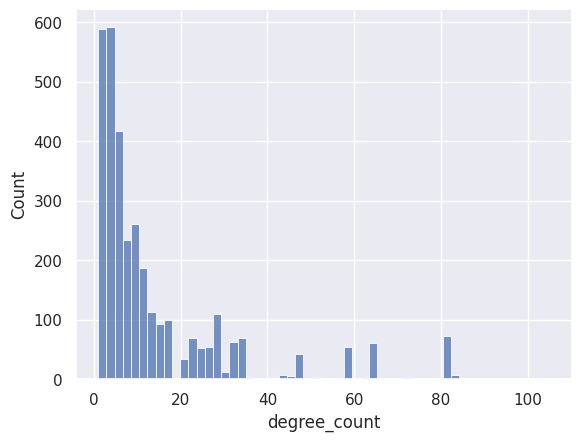

In [109]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [110]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [111]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [112]:
data['degree'].describe().to_frame()

,degree
count,3322.000000
mean,0.004256
std,0.005354
min,0.000301
25%,0.000903
50%,0.002107
75%,0.005116
max,0.031598


In [113]:
data['focus'].describe().to_frame()

,focus
count,3.322000e+03
mean,2.650198e-02
std,4.665182e-02
min,1.000000e-10
25%,7.132668e-03
50%,1.569187e-02
75%,2.505350e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

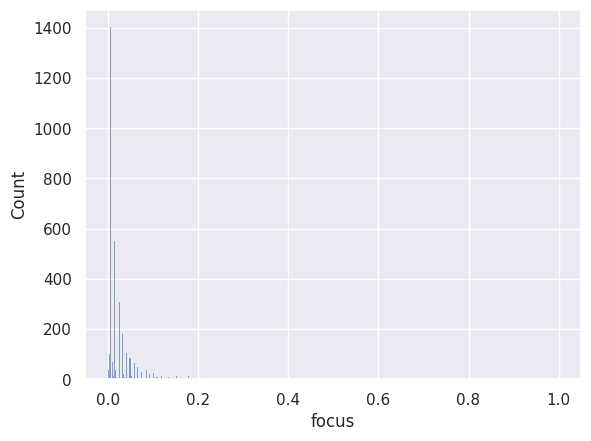

In [114]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

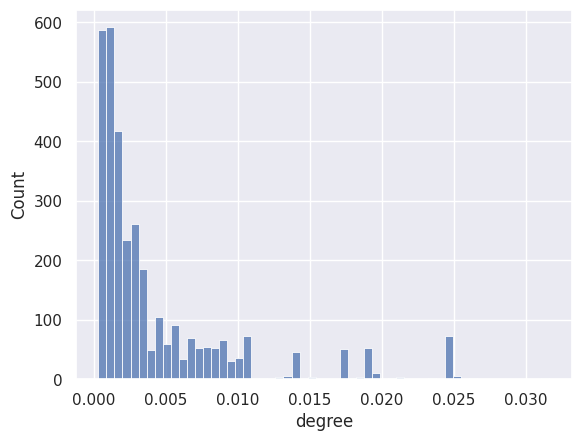

In [115]:
sns.histplot(data['degree'])

In [116]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

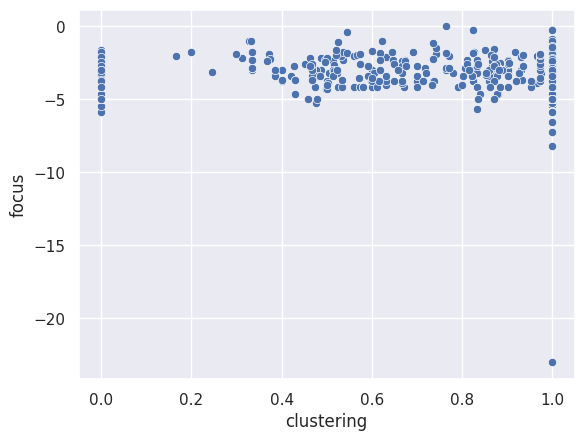

In [117]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [118]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
kaplun,1.000000e+00,117,0.764706,0.005417,18
boegel,8.031384e-01,94,1.000000,0.003611,12
stvstnfrd,8.031384e-01,94,0.825352,0.021366,71
bartvm,6.671082e-01,81,0.545455,0.003310,11
jeromekelleher,4.179743e-01,49,1.000000,0.002407,8
...,...,...,...,...,...
KesterTong,7.132669e-04,1,1.000000,0.001505,5
brunal,7.132669e-04,1,1.000000,0.000602,2
M4rtinK,2.853068e-04,1,1.000000,0.001505,5


### Residuals

In [119]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [120]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     47.30
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           7.25e-12
Time:                        19:09:00   Log-Likelihood:                 5492.4
No. Observations:                3322   AIC:                        -1.098e+04
Df Residuals:                    3320   BIC:                        -1.097e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0445      0.003     16.243      0.000       0.039       0.050
clustering    -0.0200      0.003     -6.878      0.000      -0.026      -0.014
==============================================================================
Omnibus:                     4834.024   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2210024.890
Skew:                           8.554   Prob(JB):                         0.00
Kurtosis:                     128.195   Cond. No.                         6.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.019997,0.002908,0.000000


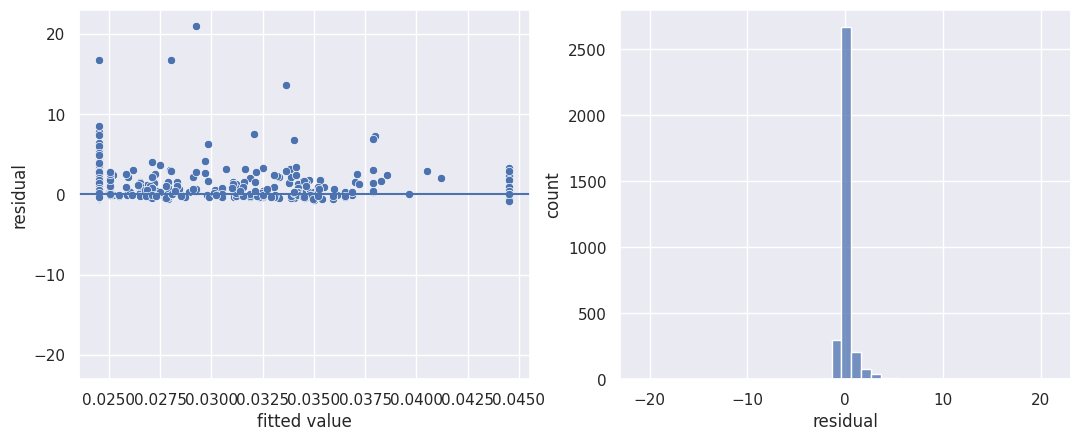

In [122]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [123]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [124]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     100.4
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           4.54e-43
Time:                        19:09:02   Log-Likelihood:                -4869.5
No. Observations:                3322   AIC:                             9745.
Df Residuals:                    3319   BIC:                             9763.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5483      0.062    -57.037      0.000      -3.670      -3.426
clustering    -0.8711      0.067    -13.053      0.000      -1.002      -0.740
degree        26.2606      3.446      7.620      0.000      19.503      33.018
==============================================================================
Omnibus:                     2642.190   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           498524.401
Skew:                          -2.915   Prob(JB):                         0.00
Kurtosis:                      62.730   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.871148,0.066737,0.000000
degree,26.260628,3.446496,0.000000


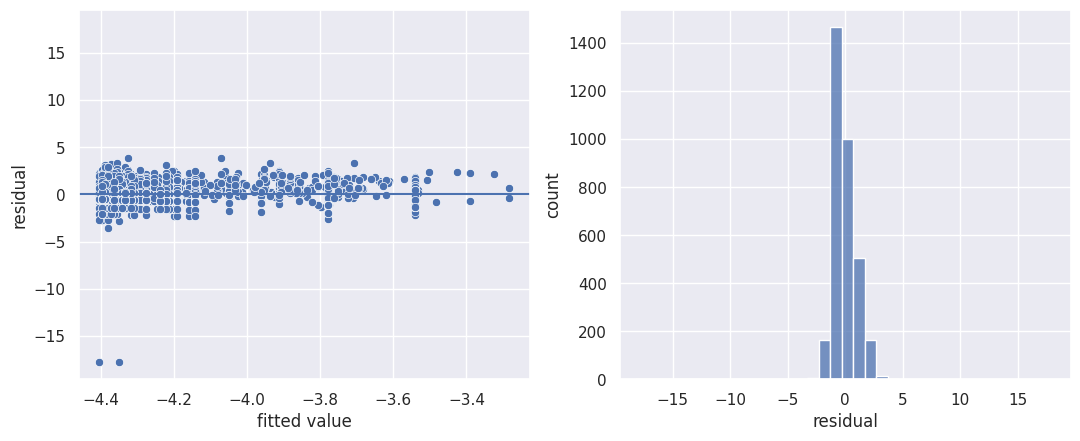

In [126]:
result.plot_residuals()

## Saving the graph

In [127]:
import netpixi

In [128]:
gt_save(g, '../networks/colabs_except_js_only_python.net.gz')